Fashion-MNIST dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes

## PART-2 - Deep Neural Network with PyTorch

1. Adding the Test / Validation set - so I can calculate both Training Loss and Accuracy and Also Test Loss and Accuracy
2. Adding Batch Normalization and improving our Model Prediction / Accuracy.
3. Plotting Parameter distribution across layers.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

# Configuration of CUDA (GPU support for PyTorch) that can be used while loading the data.
# And later to my __getitem__ function I will pass this device variable
# device = "cuda" if torch.cuda.is_available() else "cpu"

# In my case, although I have PyTorch recognizable NVIDIA GPU and so torch.cuda.is_available()
# will return TRUE, but my GPU's computer capability is < 3.5 and so will NOT work with PyTorch
device = "cpu"

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.10.1+cu113
0.11.2+cu113


In [3]:

root_input_dataset_dir = './input_dataset'

fmnist_train = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=True)

The TorchVision datasets implement __len__() and __getitem__() methods, which means that in addition to getting specific elements by index, you can also get the number of samples with the len() function:

Additionally, DataLoader classes can use TorchVision Dataset objects to create automatic batches for training.


#### Below cell code will work when NOT using `transform=transforms.ToTensor()` with `torchvision.datasets` function

In [4]:
fmnist_train[10]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F374DBB2C40>, 0)

img.size  (28, 28)
label  9


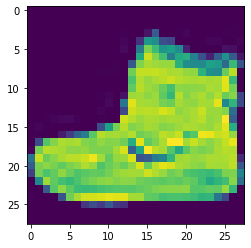

In [5]:

img, label = fmnist_train[0] # You’ll get a tuple with a Pillow image and an integer label back:
print("img.size ", img.size)
print("label ", label)
plt.imshow(img)

Now the `torchvision.datasets` function mostly returns Pillow images. So if you want Tensors to be returned - you do need to pass in a transform to convert the image to a tensor:

Where transform is a TorchVision transform to apply to the input image or video.

[Read more here](https://pytorch.org/vision/0.8/transforms.html)

#### PyTorch Transform and ToTensor()

This is a very commonly used conversion transform. In PyTorch, we mostly work with data in the form of tensors. If the input data is in the form of a NumPy array or PIL image, we can convert it into a tensor format using ToTensor.

The final tensor will be of the form (C * H * W). Along with this, a scaling operation is also performed from the range of 0–255 to 0–1.

In [6]:
# img1 = fmnist_train[10][0][0]

# plt.imshow(img1) # If I have used transform=transforms.ToTensor() while fetching with torchvision.datasets


In [7]:
# store the images and the labels
train_images = fmnist_train.data
train_img_targets = fmnist_train.targets

In [8]:
print("Train Images shape", train_images.shape)
print("train_images.size() ", train_images.size())
print("Targets.shape", train_img_targets.shape)
print("Numeric value of Unique Classes ", train_img_targets.unique())
print("Name of classes ", fmnist_train.classes)

Train Images shape torch.Size([60000, 28, 28])
train_images.size()  torch.Size([60000, 28, 28])
Targets.shape torch.Size([60000])
Numeric value of Unique Classes  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Name of classes  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Check any random single image from the train_images dataset.

torch.Size([28, 28])


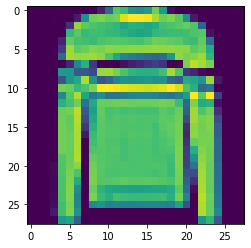

In [9]:
img = train_images[5]
print(img.size())
plt.imshow(img)

Here, we can see that there are 60,000 images each of 28 x 28 in size and with 10 possible classes across all the images. 

Note that train_img_targets contains the numeric values for each class, while `fmnist_train.classes` gives us the names that correspond to each numeric value in tr_targets.

---

#### Plot a random sample of 10 images for all the 10 possible classes:

#### So that in the below output plot of image -- each row represents a sample of 10 different images all belonging to the same class.


Loop through the unique class numbers (label_class) and fetch the indices of rows (label_x_rows) corresponding to the given class number:


label_x_rows  [    1     2     4 ... 59974 59985 59998]
label_x_rows  [   16    21    38 ... 59989 59991 59996]
label_x_rows  [    5     7    27 ... 59977 59981 59993]
label_x_rows  [    3    20    25 ... 59971 59980 59997]
label_x_rows  [   19    22    24 ... 59984 59986 59990]
label_x_rows  [    8     9    12 ... 59983 59995 59999]
label_x_rows  [   18    32    33 ... 59973 59987 59988]
label_x_rows  [    6    14    41 ... 59951 59979 59992]
label_x_rows  [   23    35    57 ... 59962 59967 59994]
label_x_rows  [    0    11    15 ... 59932 59970 59978]


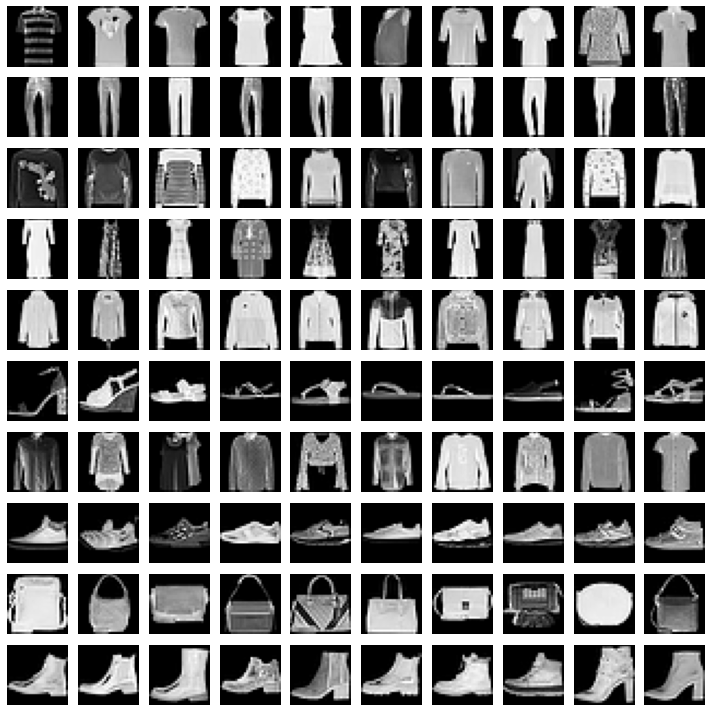

In [10]:
# Setting both row and column to be 10
row, column = len(train_img_targets.unique()), 10

fig, ax = plt.subplots(row, column, figsize=(10,10))
# ax can be either a single Axes object or an array of Axes objects if more than one subplot was created.
# here ax is a 10 by 10 tuple (10, 10) - ax.shape will give (10, 10)

for label_class, row_value in enumerate(ax):
    
    # print(row_value)
    # print('label_class ', label_class)
    # fetch the indices of rows (label_x_rows) corresponding to the given class number:        
    label_x_rows = np.where(train_img_targets == label_class)[0]    
    """     
    label_x_rows is an array of indices ( corresponding to a given class) where train_img_targets == label_class
    np.where will return me an array, and I am selecting the very first element from that.    
    Note that in the preceding code, we are fetching the 0th index as the output of the np.where condition 
    as it has a length of 1. It contains an array of all the indices where the target value (train_img_targets) is equal to label_class. """

    print('label_x_rows ', label_x_rows)    
    
    # Loop through 10 times to fill the columns of a given row. 
    for plot_cell in row_value:
        plot_cell.grid(False); plot_cell.axis('off')
        
        # label_x_rows is an array of indices ( corresponding to a given class) where train_img_targets == label_class
        # e.g. label_x_rows => [    1     2     4 ... 59974 59985 59998]
        # From that array pick a single indices for plotting
        rand_image_idx = np.random.choice(label_x_rows)
        x, y = train_images[rand_image_idx], train_images[rand_image_idx]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

In [11]:
fmnist_test = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=False )

torch.Size([28, 28])


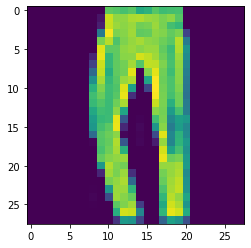

In [12]:
test_images = fmnist_test.data
test_img_targets = fmnist_test.targets

random_test_img = test_images[5]
print(random_test_img.size())
plt.imshow(random_test_img)


In [13]:
class DatasetTransformer(Dataset):
  """ Will take 2 arrays/tensors for parameters train_images (x) and train_img_targets (y) """
  def __init__(self, x, y):
    # converting the input into a floating-point number 
    # And also scale them to the range of [0,1] by dividing by 255
    x = x.float()/255
    
    # Flattened each image into 28*28 = 784 numeric values
    # where each numeric value corresponds to a pixel value
    x = x.view(-1, 28 * 28)
    self.x, self.y = x, y    
    
    
  # __getitem__ function returns a sample from the dataset given an index.
  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]    
    # It is necessary to have both the model, and the data on the same device, 
    # either CPU or GPU, for the model to process data. 
    # Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.
    # to(device) => this method will move the tensor or model to the specified device.
    return x.to(device), y.to(device)
    
  # __len__ function which returns the size of the dataset, 
  def __len__(self):
    return len(self.x)
  

Create a function that generates a training DataLoader – train_dataloader from the dataset. This will sample 32 data points at random for the batch size:

In [14]:
def load_data():
  # Load Train Data
  train_data = DatasetTransformer(train_images, train_img_targets)
  train_loaded_data = DataLoader(train_data, batch_size=32, shuffle=True) 
  
  #Load Test Data
  test_data = DatasetTransformer(test_images, test_img_targets)
  test_loaded_data = DataLoader(test_data, len(test_images), shuffle=False )
  
  return train_loaded_data, test_loaded_data

In [15]:
from torch.optim import SGD

# def run_model():
#   model = nn.Sequential(
#     nn.Linear(28 * 28,  1000),
#     nn.ReLU(),
#     nn.Linear(1000, 10)
#   ).to(device)
  
#   loss_fn = nn.CrossEntropyLoss()
#   optimizer = SGD(model.parameters(), lr=0.01)
#   return model, loss_fn, optimizer

In [16]:
def run_model():
  """
    This function defines a simple neural network model, the loss function, and the optimizer.
    The neural network consists of an input layer, a hidden layer with batch normalization and
    ReLU activation, and an output layer. It uses Cross-Entropy as the loss function and Stochastic 
    Gradient Descent as the optimizer.

    Returns:
    --------
    model : nn.Module
        The defined neural network model.
    
    loss_fn : nn.CrossEntropyLoss
        The loss function used for training the model.
    
    optimizer : torch.optim.SGD
        The optimizer used for training the model.
    """  
  # Define the neural network architecture  
  class neuralnetwork(nn.Module):
    def __init__(self):
      super().__init__()
      self.input_to_hidden_layer = nn.Linear(784, 1000)
      self.batch_norm = nn.BatchNorm1d(1000)
      self.hidden_layer_activation = nn.ReLU()
      self.hidden_to_output_layer = nn.Linear(1000, 10)
      
    def forward(self, x):
      x = self.input_to_hidden_layer(x)
      fc0 = self.batch_norm(x)
      fc1 = self.hidden_layer_activation(fc0)
      fc2 = self.hidden_to_output_layer(fc1)
      return fc2, fc1
    
  model = neuralnetwork().to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=0.01)
  return model, loss_fn, optimizer
  

In [17]:
@torch.no_grad()

def test_loss(x, y, model):
  prediction = model(x)[0]
  test_loss = loss_fn(prediction, y)
  return test_loss.item()

In [18]:
def trainer_each_batch(x, y, model, optimizer, loss_fn):
    model.train()
    # call model on the batch of inputs
    # `model.train()` tells your model that you are training the model. 
    # So BatchNorm layers use per-batch statistics and Dropout layers are activated etc
    # Forward pass: Compute predicted y by passing x to the model
    prediction = model(x)[0]
    # "prediction = model(x)" executes forward propagation over x 
    
    # compute loss
    loss_for_this_batch = loss_fn(prediction, y)
    
    # based on the forward pass in `model(x)` compute all the gradients of model.parameters()
    # loss.backward() computes dloss/dx for every parameter x 
    # which has requires_grad=True. These are accumulated into x.grad for every parameter x.
    # In pseudo-code:
    # x.grad += dloss/dx
    loss_for_this_batch.backward()
    
    """ apply new-weights = f(old-weights, old-weight-gradients) where "f" is the optimizer 
    When you call `loss.backward()`, all it does is compute gradient of loss w.r.t all the parameters in loss that have `requires_grad = True` and store them in `parameter.grad` attribute for every parameter.

    `optimizer.step()` updates all the parameters based on `parameter.grad`
    """
    
    optimizer.step()
    
    # Flush gradients memory for next batch of calculations
    # `optimizer.zero_grad()` clears `x.grad` for every parameter x in the optimizer.
    # Not zeroing grads would lead to gradient accumulation across batches.
    optimizer.zero_grad()
    
    return loss_for_this_batch.item()

The trainer_each_batch function does the following this

1. Passes the batch of images through the model in the forward pass. 
3. Computes the loss on batch
4. Then passes the weights through backward propagation and updates them. 
5. Finally, it flushes the memory of the gradient so that it doesn't influence how the gradient is calculated in the next pass.

In [19]:
""" torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script). 
So torch.no_grad() basically skips the gradient calculation over the weights. That means you are not changing any weight in the specified layers. 

If you are training pre-trained model, it's ok to use torch.no_grad() on all the layers except fully connected layer or classifier layer.

"""
@torch.no_grad()

def accuracy(x, y, model):
  
    # model.eval() will notify all your layers that you are in eval mode,
    # that way, batchnorm or dropout layers will work in eval mode instead of training mode.  
    model.eval()
    
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)[0]
    
    # Now compute if the location of maximum in each row coincides with ground truth
    # For that first, I am identifying the argmax index corresponding to each row with prediction.max(-1)
    max_values, argmaxes = prediction.max(-1)

    """ comparing argmaxes with the ground truth through with argmaxes == y
    to check that each row is predicted correctly.  """
    
    is_correct = argmaxes == y
    
    return is_correct.cpu().numpy().tolist()

In [20]:
training_data_loader, test_loaded_data = load_data()
model, loss_fn, optimizer = run_model()

In [21]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(5):
    print(epoch)
    
    # Iteration to calculate train_losses
    # Creating lists that will contain the accuracy and loss values corresponding to each batch within an epoch:
    losses_in_this_epoch, train_accuracies_in_this_epoch = [], []
    
    # Create batches of training data by iterating through the DataLoader:
    for ix, batch in enumerate(iter(training_data_loader)):
        x, y = batch
        """ Train the batch using the trainer_each_batch() function and store the loss value at
        the end of training on top of the batch as loss_for_this_batch. 
        Furthermore, store the loss values across batches in the losses_in_this_epoch list:
        """
        loss_for_this_batch = trainer_each_batch(x, y, model, optimizer, loss_fn)
        losses_in_this_epoch.append(loss_for_this_batch)
    
    # After the above loop is done 
    # store the mean loss value across all batches within an epoch:    
    train_epoch_loss = np.array(losses_in_this_epoch).mean()
    
    # Iteration to calculate train_accuracies
    # Next, we calculate the accuracy of the prediction at the end of training on all batches:
    for ix, batch in enumerate(iter(training_data_loader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_accuracies_in_this_epoch.extend(is_correct)
    epoch_accuracy = np.mean(train_accuracies_in_this_epoch)
    
    """ Calculate the loss value and accuracy within the one batch of test data
    Note, that the batch size of the test data is equal to the length of the entire test data. 
    So its just a single batch to cover the entire test data.
    """
    for ix, batch in enumerate(iter(test_loaded_data)):
      x, y = batch
      test_is_correct = accuracy(x, y, model)
      test_epoch_loss = test_loss(x, y, model)
      
      
    test_epoch_accuracy = np.mean(test_is_correct)
    
       
    
    train_losses.append(train_epoch_loss)
    
    train_accuracies.append(epoch_accuracy)
    
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_accuracy)

0
1
2
3
4


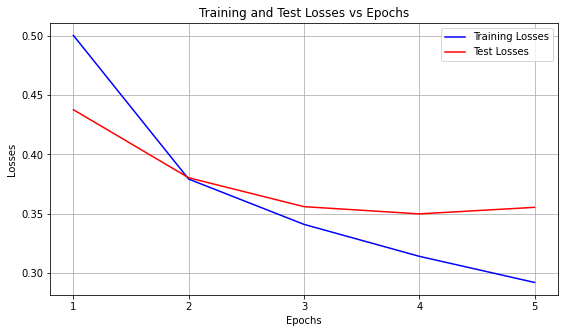

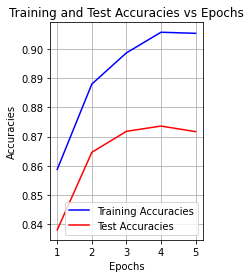

In [22]:
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

epochs = np.arange(5)+1

plt.figure(figsize=(20,5))

plt.subplot(121)

plt.plot(epochs, train_losses, 'blue', label='Training Losses')
plt.plot(epochs, test_losses, 'r', label='Test Losses')

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and Test Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(122)

plt.plot(epochs, train_accuracies, 'blue', label='Training Accuracies')
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracies')

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.title('Training and Test Accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.grid('off')
plt.show()





There are four parameter groups in our model:

* Weights in the layer connecting the input layer to the hidden layer
* Bias in the hidden layer
* Weights in the layer connecting the hidden layer to the output layer
* Bias in the output layer

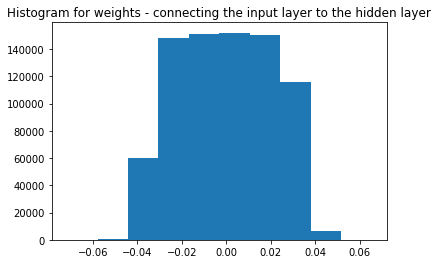

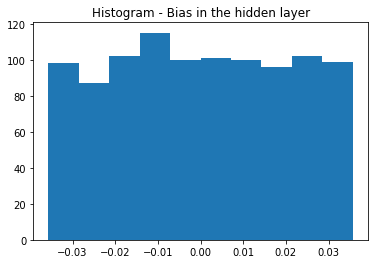

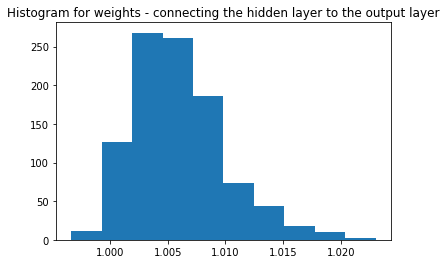

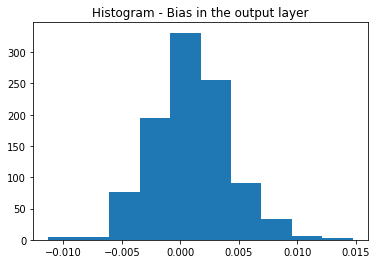

In [24]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram for weights - connecting the input layer to the hidden layer")
    plt.show()
  if(ix==1):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram - Bias in the hidden layer")
    plt.show()
  if(ix==2):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram for weights - connecting the hidden layer to the output layer")
    plt.show()
  if(ix==3):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram - Bias in the output layer")
    plt.show()